# Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay

In [2]:
players = pd.read_csv("../data/players_fe.csv")

# Train-Test Split

In [3]:
X = players.drop(columns=["log_market_value"])
y = players["log_market_value"]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42,
)

# 1️⃣ Pipelines

## Preprocessing: Impute + Scale (num), Impute + OneHot (cat)

In [5]:
cat_cols = X_train.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X_train.select_dtypes(include=[np.number,"float","int"]).columns.tolist()

In [6]:
numeric_pre = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])

In [7]:
categorical_pre = Pipeline(steps=[
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

In [8]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_pre, num_cols),
        ("cat", categorical_pre, cat_cols),
    ],
    remainder="drop"
)


## Drei Modell-Pipelines
- einfach: Ridge
- medium: RandomForest
- stark: HistGradientBoosting

In [9]:
pipe_ridge = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", Ridge(random_state=42))
])

In [10]:
pipe_rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

In [11]:
pipe_hgb = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", HistGradientBoostingRegressor(random_state=42))
])

# 2️⃣ Hyperparameter-Tuning

In [12]:
grid_ridge = {
    "model__alpha": [0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0],
}

grid_rf = {
    "model__n_estimators": [300, 400],
    "model__max_depth": [15, 25],
    "model__min_samples_leaf": [1, 3, 5],
    "model__max_features": ["sqrt", 0.8],
}

grid_hgb = {
    "model__learning_rate": [0.03, 0.1],
    "model__max_leaf_nodes": [31, 63, 127],
    "model__max_depth": [None, 10],
    "model__l2_regularization": [0.0, 0.1],
    "model__max_iter": [300],
}

In [13]:
def run_grid(name, pipe, grid):
    gs = GridSearchCV(
        estimator=pipe,
        param_grid=grid,
        scoring="neg_mean_absolute_error",
        cv=5,
        n_jobs=-1,
        verbose=0
    )

    gs.fit(X_train, y_train)

    y_pred = gs.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = root_mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\n{name} — Best params: {gs.best_params_}")
    print(f"{name} — CV best neg-MAE: {gs.best_score_:.4f}")
    print(f"{name} — Test MAE:  {mae:.4f}")
    print(f"{name} — Test RMSE: {rmse:.4f}")
    print(f"{name} — Test R²:   {r2:.4f}")
    
    return {"name": name, "grid": gs, "mae": mae, "rmse": rmse, "r2": r2}

# 3️⃣ Evaluation

- MAE = durchschnittliche absolute Unterschied zwischen den vorhergesagten und den tatsächlichen Werten (je kleiner, desto genauer)
- RMSE = durchschnittliche Größe der Fehler, wobei größere Fehler stärker gewichtet werden (je kleiner, desto besser)
- R² = Varianz in den Zielwerten (je näher gegen 1, desto besser)

In [14]:

results = []

results.append(run_grid("Ridge (simple)", pipe_ridge, grid_ridge))
results.append(run_grid("RandomForest (medium)", pipe_rf, grid_rf))
results.append(run_grid("HistGB (strong)", pipe_hgb, grid_hgb))

rank = pd.DataFrame(results).sort_values("mae")
print("\n=== Model ranking (by Test MAE) ===")
rank[["name","mae","rmse","r2"]]



Ridge (simple) — Best params: {'model__alpha': 10.0}
Ridge (simple) — CV best neg-MAE: -0.7793
Ridge (simple) — Test MAE:  0.7641
Ridge (simple) — Test RMSE: 0.9794
Ridge (simple) — Test R²:   0.6073


/Users/antonioaleksic/Documents/ADSC21/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



RandomForest (medium) — Best params: {'model__max_depth': 25, 'model__max_features': 0.8, 'model__min_samples_leaf': 1, 'model__n_estimators': 400}
RandomForest (medium) — CV best neg-MAE: -0.6183
RandomForest (medium) — Test MAE:  0.6028
RandomForest (medium) — Test RMSE: 0.7875
RandomForest (medium) — Test R²:   0.7461

HistGB (strong) — Best params: {'model__l2_regularization': 0.0, 'model__learning_rate': 0.03, 'model__max_depth': None, 'model__max_iter': 300, 'model__max_leaf_nodes': 127}
HistGB (strong) — CV best neg-MAE: -0.5916
HistGB (strong) — Test MAE:  0.5775
HistGB (strong) — Test RMSE: 0.7547
HistGB (strong) — Test R²:   0.7668

=== Model ranking (by Test MAE) ===


,name,mae,rmse,r2
2,HistGB (strong),0.577514,0.754705,0.766830
1,RandomForest (medium),0.602754,0.787514,0.746116
0,Ridge (simple),0.764148,0.979402,0.607319


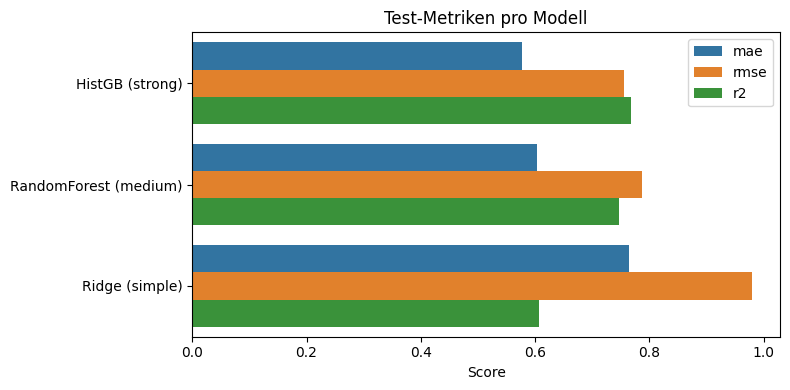

In [15]:
rank_plot = rank.melt(id_vars="name", value_vars=["mae", "rmse", "r2"], var_name="metric", value_name="score")

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(data=rank_plot, x="score", y="name", hue="metric", ax=ax)
ax.set_title("Test-Metriken pro Modell")
ax.set_xlabel("Score")
ax.set_ylabel("")
ax.legend(title="")
plt.tight_layout()
plt.show()

# 4️⃣ XAI

In [ ]:
histgb_best = results[-1]["grid"].best_estimator_
prep = histgb_best.named_steps["prep"]
model = histgb_best.named_steps["model"]

X_test_enc = prep.transform(X_test).astype(float)
feature_names = prep.get_feature_names_out()

perm = permutation_importance(
    model,
    X_test_enc,
    y_test,
    n_repeats=20,
    random_state=42,
    n_jobs=-1,
)

feat_imp = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

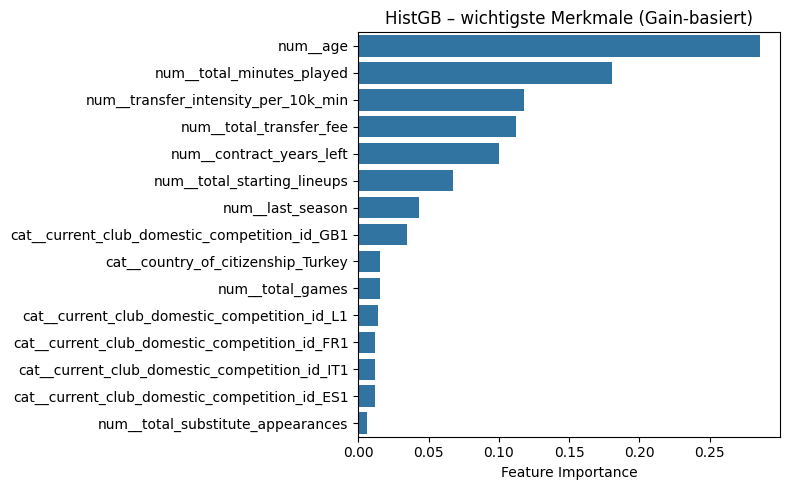

In [ ]:
top_x = 15
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(x=feat_imp.values[:top_x], y=feat_imp.index[:top_x], ax=ax, orient="h")
ax.set_title("HistGB – wichtigste Merkmale (Gain-basiert)")
ax.set_xlabel("Feature Importance")
ax.set_ylabel("")
plt.tight_layout()
plt.show()

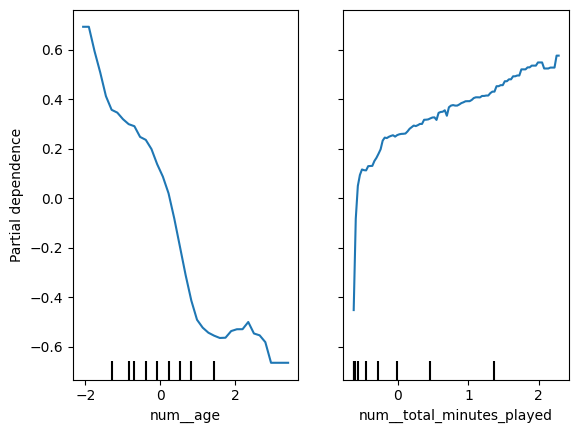

In [ ]:
top_features = feat_imp.index[:2]
feature_idx = [list(feature_names).index(name) for name in top_features]

PartialDependenceDisplay.from_estimator(
    model,
    X_test_enc,
    features=feature_idx,
    feature_names=feature_names,
    kind="average",
)
plt.show()

- **num_age**
	- Die Kurve fällt stark ab --> höhere Werte von num_age (also ältere Spieler) reduzieren die Modellvorhersage
	- bei niedrigen Werten (jüngeren Spielern) ist der Einfluss positiv auf x
	- Interpretation: Alter wirkt sich negativ auf die Zielgröße aus (z. B. Leistung, Punktzahl, etc.)

- **num_total_minutes_played**
	- Die Kurve steigt an --> je mehr Minuten gespielt wurden, desto höher wird die Vorhersage des Modells
	- Die Beziehung scheint sättigend, d. h. der Zuwachs flacht mit zunehmender Spielzeit ab
	- Interpretation: Mehr Spielzeit hat einen positiven Einfluss auf das Ziel (bis zu einem Plateau)

In [20]:
def collect_preds(estimator, X, y, split):
    pred = estimator.predict(X)
    df = pd.DataFrame({"split": split, "actual_log": y, "pred_log": pred}, index=X.index)
    df["actual_value"] = np.exp(df["actual_log"])
    df["pred_value"] = np.exp(df["pred_log"])
    df["residual_log"] = df["actual_log"] - df["pred_log"]
    df["abs_error_value"] = np.abs(df["pred_value"] - df["actual_value"])
    return df

pred_train = collect_preds(histgb_best, X_train, y_train, "train")
pred_test = collect_preds(histgb_best, X_test, y_test, "test")
pred_df = pd.concat([pred_train, pred_test])

pred_details = pred_df.join(players.loc[pred_df.index, ["position", "age", "country_of_citizenship"]])
pred_details.head()

,split,actual_log,pred_log,actual_value,pred_value,residual_log,abs_error_value,position,age,country_of_citizenship
18337,train,10.819798,12.177403,50001.0,1.943476e+05,-1.357605,1.443466e+05,Attack,28,England
14068,train,12.206078,12.050905,200001.0,1.712543e+05,0.155173,2.874669e+04,Goalkeeper,31,Portugal
11374,train,11.918397,12.250980,150001.0,2.091862e+05,-0.332583,5.918517e+04,Midfield,29,Norway
11034,train,12.611541,12.533449,300001.0,2.774648e+05,0.078092,2.253622e+04,Goalkeeper,31,France
19756,train,15.761421,15.313200,7000001.0,4.471345e+06,0.448221,2.528656e+06,Defender,29,Unknown


Die Tabelle zeigt die Vorhersageergebnisse aus dem HistGB im Vergleich zu den tatsächlichen Werten

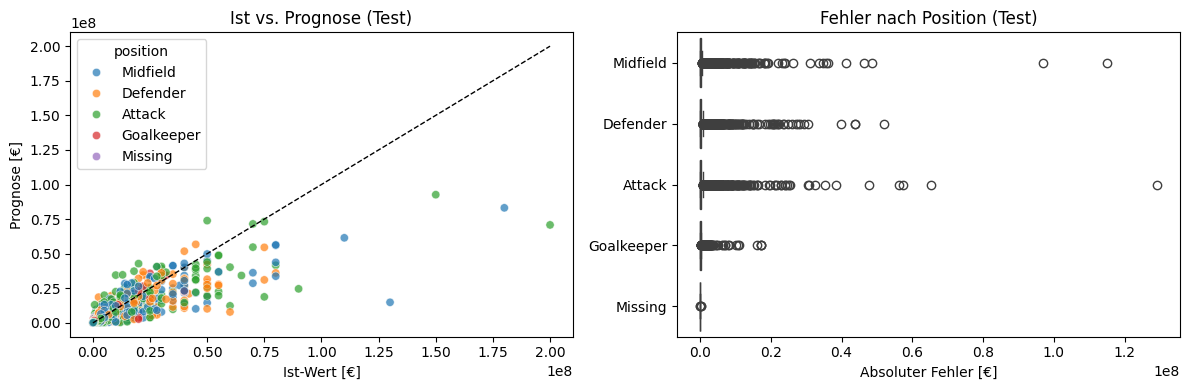

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
sns.scatterplot(data=pred_details.query("split == 'test'"),
                x="actual_value", y="pred_value", hue="position", ax=ax[0], alpha=0.7)
ax[0].plot([pred_df["actual_value"].min(), pred_df["actual_value"].max()],
           [pred_df["actual_value"].min(), pred_df["actual_value"].max()],
           color="black", linestyle="--", linewidth=1)
ax[0].set_title("Ist vs. Prognose (Test)")
ax[0].set_xlabel("Ist-Wert [€]")
ax[0].set_ylabel("Prognose [€]")

sns.boxplot(data=pred_details.query("split == 'test'"),
            x="abs_error_value", y="position", ax=ax[1])
ax[1].set_title("Fehler nach Position (Test)")
ax[1].set_xlabel("Absoluter Fehler [€]")
ax[1].set_ylabel("")
plt.tight_layout()
plt.show()

- HistGB funktioniert solide für typische Werte (unten links im Scatterplot)
- unterschätzt hohe Marktwerte (oben links unterhalb der Diagonale)
- hat je nach Position unterschiedlich starke Fehler — für manche Positionen fehlen Trainingsdaten oder sie haben untypische Merkmale (gerade Defender Statistiken fehlen)

In [ ]:
kpi_table = (
    pred_df.groupby("split")
    .agg(
        mae_log=("residual_log", lambda s: s.abs().mean()),
        rmse_log=("residual_log", lambda s: np.sqrt((s**2).mean())),
        median_abs_error_mio=("abs_error_value", lambda s: np.median(s) / 1e6),
        mape=("abs_error_value", lambda s: np.mean(s / pred_df.loc[s.index, "actual_value"]))
    )
)

formatted_kpi = kpi_table.copy()
formatted_kpi["mae_log"] = formatted_kpi["mae_log"].round(3)
formatted_kpi["rmse_log"] = formatted_kpi["rmse_log"].round(3)
formatted_kpi["median_abs_error_mio"] = formatted_kpi["median_abs_error_mio"].round(2)
formatted_kpi["mape"] = formatted_kpi["mape"].map(lambda v: f"{v:.1%}")

formatted_kpi

,mae_log,rmse_log,median_abs_error_mio,mape
split,,,,
test,0.578,0.755,0.10,74.2%
train,0.444,0.589,0.08,51.9%


- mae_log = der durchschnittliche absolute Fehler zwischen tatsächlichem und vorhergesagtem Log-Wert
- rmse_log = quadratischer Fehler im Log-Raum; stärker von Ausreißern beeinflusst
- median_abs_error_mio = Median des absoluten Fehlers in Millionen € – zeigt, wie stark sich die typische Vorhersage in den Originalwerten unterscheidet
- mape = durchschnittlicher prozentualer Fehler im Originalmaßstab (zeigt, wie stark das Modell im Verhältnis zum tatsächlichen Wert danebenliegt)

- Das Modell liegt zwischen 80.000€ – 100.000€ daneben — für Marktwert-Schätzungen, bei kleine Clubs ist das recht ordentlich, je nach Wertebereich
- hat im Test eine akzeptable, aber noch verbesserungswürdige Genauigkeit,
- neigt leicht zu Unterschätzung bei hohen Werten,
- und zeigt eine Fehlerstreuung, die positionsabhängig ist (siehe vorherige Visualisierung)

# 5️⃣ Fazit - Suchverfahren & Produktivnahme

- Das Tuning nutzt ein exhaustives GridSearchCV mit 5-fach-Kreuzvalidierung
- Vorteil: reproduzierbar in engem Hyperparameterraum; Nachteil: skaliert schlecht, weil jeder Parameter-Kombination alle 5 Folds durchlaufen muss (hohe Auslastung)

- Für breitere Räume oder schnellere Iteration in Produktion lohnt sich RandomizedSearchCV oder HalvingGridSearchCV, ggf. kombiniert mit früherem Stoppen (max_iter) beim HistGB
- Außerdem wäre gut statistische Wiederholbarkeit sicherstellen (Random-States fixieren, Seeds propagieren)

- Vor Produktivnahme:
    - Datenversorgung stabilisieren (gleiche Feature-Engineeringschritte wie in preprocessor)
    - Pipeline serialisieren (joblib.dump(histgb_best, "model.joblib")) und gemeinsam mit Spaltenliste/versionierten Artefakten deployen
    - Beim Retraining den finalen Pipeline-Fit auf dem kompletten Datensatz (Train+Test) durchführen;
    - KPI-Reporting sollte auf einem separaten Hold-out oder Cross-Validation verbleiben, um Drift zu erkennen
    - Log-Target beachten - Monitoring in Originaleinheit etablieren (z. B. Median absoluter Fehler in Mio. €). Bei Serving die Ausgaben exponentieren und ggf. in Monetarisierungskorridore clampen
    - Performance & Skalierung: HistGB ist rein CPU-basiert; plane Latenztests mit realistischem Request-Profil
    - Für Batch-Szenarien kann der Pipeline-Transformer vorab auf NumPy konvertieren (pipeline.predict bereits erledigt), für Realtime ggfs. predict parallelisieren
    - Abschließend ein ML-Ops-Setup vorsehen (Versionierung, automatisierte Retrains, KPI-Dashboard) und Tests für Datenvalidität/Schema integrieren, damit die im Notebook erzielten Ergebnisse im operativen Betrieb konsistent bleiben